# About

This is an integrated notebook for the modeling (training & testing) process of MinSatu's ("-1") recommendation algorithm.

Should you wish to run only for the new user inference, you only need to run this one cell right below and the cells under the "Inference Recommendations for New User" heading

In [2]:
#Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
from keras.models import load_model

#Defining preprocessing function
def preprocess_dt(dt_users, dt_activities, dt_join = [], dt_bucket = [], infer=False):
    
    #Preprocessing user dataset 
    #Slice necessary columns and convert the ID to start from 0
    dt_users = dt_users.iloc[:, :-1]
    dt_users['user_id'] = dt_users['user_id'].apply(lambda x: x-1)
    
    #Reordering the gender column position and dropping unnecessary columns
    dt_users['gender_P'] = dt_users['gender']
    dt_users.drop(columns = ['user_name', 'email', 'passwords', 'gender'], inplace = True)
    
    
    #Preprocessing activity dataset
    #Slice necessary columns and convert the ID to start from 0
    dt_activities = dt_activities.iloc[:, :-4]
    dt_activities['act_id'] = dt_activities['act_id'].apply(lambda x: x-1)
    
    #Convert the datetime columns into datetime dtype
    fmt = '%Y-%m-%d %H:%M:%S'
    dt_activities['time_start'] = dt_activities['time_start'].apply(lambda x: datetime.strptime(x, fmt))
    dt_activities['time_end'] = dt_activities['time_end'].apply(lambda x: datetime.strptime(x, fmt))
    
    #Calculating the duration variable from the differences of ending and starting datetime
    dt_activities['duration'] = dt_activities['time_end'] - dt_activities['time_start']
    dt_activities['duration'] = dt_activities['duration'].apply(lambda x:(x.days * 24 * 60) + (x.seconds/60))
    
    #Calculating the daytime binary variable from ending and starting datetime
    daytime_start = dt_activities["time_start"].apply(lambda x: 1 if 6<= x.hour <= 18 else 0)
    daytime_end = dt_activities["time_end"].apply(lambda x: 1 if 6<= x.hour <= 18 else 0)
    dt_activities["daytime"] = [1 if daytime_start[x]==1 and daytime_end[x]==1 and dt_activities["duration"][x] < (12*60) else 0 for x in range(len(daytime_start))]
    
    #Parsing the category value into one-hot variables
    dt_activities['sports'] = dt_activities['category'].apply(lambda x: 1 if "sports" in x else 0)
    dt_activities['arts'] = dt_activities['category'].apply(lambda x: 1 if "arts" in x else 0)
    dt_activities['travel'] = dt_activities['category'].apply(lambda x: 1 if "travel" in x else 0)
    dt_activities['edu'] = dt_activities['category'].apply(lambda x: 1 if "edu" in x else 0)
    
    #Calculating the weekend binary variable from ending and starting datetime
    weekend_start = dt_activities["time_start"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
    weekend_end = dt_activities["time_end"].apply(lambda x: 1 if x.weekday() in [5,6] else 0)
    dt_activities["weekend"] = [1 if weekend_start[x]==1 or weekend_end[x]==1 else 0 for x in range(len(weekend_start))]
    
    #One-hot the community variables and drop unnecessary columns
    dt_activities = pd.get_dummies(dt_activities, columns=['community'], drop_first=True)
    dt_activities.drop(columns = ['act_name', 'time_start', 'time_end', 'location', 'category'], inplace=True)
    
    #Creating user-activity interaction matrix
    matrix = np.zeros((len(dt_users), len(dt_activities)), dtype=int)
    if infer==False:
        #Preprocessing joined and bucketed dataset
        #Slice only necessary columns and concatenate into one interaction dataset
        dt_join = dt_join.iloc[:,1:-1]
        dt_bucket = dt_bucket.iloc[:,1:-1]
        dt_interact = pd.concat([dt_join, dt_bucket], ignore_index=True) 
        
        #Transform into interaction matrix and turn it into dataframe
        for i in range(len(dt_interact)):
            row = int(dt_interact['user_id'][i]-1)
            col = int(dt_interact['act_id'][i]-1)
            matrix[row][col] = 1
    else:
        pass
    
    matrix = pd.DataFrame(matrix)
    #Stacking the matrix back into tabular structure and merging with join left the data from users and activities dataset
    dt_interact = matrix.stack(dropna=True).reset_index().rename(columns={"level_0":"user_id", "level_1":"act_id", 0:"y"})    
    dt_interact = dt_interact.merge(dt_activities, how="left", left_on="act_id", right_on="act_id")
    
    if infer==True:
        dt_interact['user_id'].replace([0], dt_users['user_id'][0], inplace = True)
    else:
        pass
    
    dt_interact = dt_interact.merge(dt_users, how="left", left_on="user_id", right_on="user_id")
    
    
    #Preprocessing predictor and target variable
    #Slice necessary values accordingly
    y = dt_interact.iloc[:,2]
    X = dt_interact.iloc[:,3:]
    
    if infer==False:
        #Oversample the minority class data into 50% of the majority class
        ros = RandomOverSampler(sampling_strategy= 0.5,random_state=1)
        X, y = ros.fit_resample(X, y)
    else:
        pass
    
    #Slice necessary act and user features accordingly
    xact = X.iloc[:,:-8]
    xuser = X.iloc[:,-8:]
    
    #Standardize the scale of act features
    scalerAct = StandardScaler()
    scalerAct.fit(xact)
    xact = scalerAct.transform(xact)
    
    #Standardize the scale of user features
    scalerUser = StandardScaler()
    scalerUser.fit(xuser)
    xuser = scalerUser.transform(xuser)
    
    # scalerTarget = StandardScaler()
    # scalerTarget.fit(y)
    # y = scalerTarget.transform(y)
    
    if infer==False:
        #Split into training and testing subsets with stratify
        xact_train, xact_test, xuser_train, xuser_test, y_train, y_test = train_test_split(xact, xuser, y,
                                                                                           train_size=0.80,
                                                                                           shuffle=True,
                                                                                           random_state=1,
                                                                                           stratify=y
                                                                                          )
        return xact_train, xact_test, xuser_train, xuser_test, y_train, y_test
    
    else:
        return xuser, xact

def run_model(xuser, xact, model_filename = 'model.h5'):
    
    tf.random.set_seed(1)
    saved_model = load_model(model_filename, compile=False)
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    cost_fn = tf.keras.losses.BinaryFocalCrossentropy()
    auc = tf.keras.metrics.AUC(name="auc")
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    saved_model.compile(optimizer=opt, loss=cost_fn, metrics = auc)
        
    y_out = saved_model.predict([xuser, xact])
    
    return y_out, saved_model

def eval_model(y_true, y_out, saved_model):
    zmax=0
    threshold_opt=0
    
    for threshold in np.arange(0.25, 0.5, 0.01):
        y_pred = np.array([1 if i >= threshold else 0 for i in y_out])
        z = f1_score(y_true, y_pred, average='weighted', zero_division = 0)
        if z >= zmax:
            zmax = z
            threshold_opt = round(threshold, 2)
            
    print(f"Optimum threshold: {threshold_opt}")
    y_pred = np.array([1 if i >= threshold_opt else 0 for i in y_out])
    
    cr = classification_report(y_true, y_pred, zero_division = 0)
    cm = confusion_matrix(y_true, y_pred)
    
    print(cr)
    print(cm)
    
    return threshold_opt, cr, cm

def haversine(lat1, lon1, lat2, lon2):

    # Convert decimal degrees to radians
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)
    
    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    radius = 6371  # Radius of the Earth in kilometers
    distance = radius * c
    
    # return distance between the two points in kilometers.
    return distance

def user_inference(user_dict):
    #Convert the new user dictionary into a dataframe
    dt_users = pd.DataFrame(user_dict, index = [0])
    dt_activities = pd.read_csv("C23-PS137 Deliverables & Timeline Capstone Project - activities.csv")

    dist = []
    for i in range(len(dt_activities)):
      dist.append(haversine(dt_users["latitude"], dt_users["longitude"], dt_activities["latitude"][i], dt_activities["longitude"][i]))

    #Preprocess with the defined function
    xuser, xact = preprocess_dt(dt_users, dt_activities, infer=True)
    
    #Run inference with the defined function
    y_out, _ = run_model(xuser, xact, 'model.h5')
    
    #Sorting the values from the highest probability of interest and showing the corresponding activity id
    y_out = pd.DataFrame(y_out)
    y_out["distance"] = dist     
    y_out.sort_values(by=[0, 'distance'], ascending=[False, True], inplace=True)
    rank = y_out.index + 1
    return rank, y_out

## Model Building

In [3]:
#Import datasets
dt_users = pd.read_csv("C23-PS137 Deliverables & Timeline Capstone Project - users.csv")
dt_activities = pd.read_csv("C23-PS137 Deliverables & Timeline Capstone Project - activities.csv")
dt_join = pd.read_csv("C23-PS137 Deliverables & Timeline Capstone Project - user_joined.csv")
dt_bucket = pd.read_csv("C23-PS137 Deliverables & Timeline Capstone Project - user_bucketed.csv")

In [4]:
xact_train, xact_test, xuser_train, xuser_test, y_train, y_test = preprocess_dt(dt_users, dt_activities, dt_join, dt_bucket)

print("% of y_train = 0: ", (y_train[y_train == 0].shape[0])/y_train.shape[0]*100)
# print("% of y_train = Bucket: ", (y_train[y_train[:,1] == 1].shape[0])/y_train.shape[0]*100)
print("% of y_train = Joined or Bucketlisted: ", (y_train[y_train == 1].shape[0])/y_train.shape[0]*100)

print("\n% of y_test = 0: ", (y_test[y_test == 0].shape[0])/y_test.shape[0]*100)
# print("% of y_test = Bucket: ", (y_test[y_test[:,1] == 1].shape[0])/y_test.shape[0]*100)
print("% of y_test = Joined or Bucketlisted: ", (y_test[y_test == 1].shape[0])/y_test.shape[0]*100)

% of y_train = 0:  66.68626874448692
% of y_train = Joined or Bucketlisted:  33.31373125551308

% of y_test = 0:  66.62749706227967
% of y_test = Joined or Bucketlisted:  33.37250293772033


In [5]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([   
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_outputs, activation='relu')
])

act_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_outputs, activation='relu')
])

num_user_features = xuser_train.shape[1] 
num_act_features = xact_train.shape[1]

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

# create the item input and point to the base network
input_act = tf.keras.layers.Input(shape=(num_act_features))
va = act_NN(input_act)
va = tf.linalg.l2_normalize(va, axis=1)

# compute the dot product of the two vectors vu and va
dot = tf.keras.layers.Dot(axes=1)([vu, va])
o_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),                      
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_regularizer = tf.keras.regularizers.L2(l2= 20.0),
                          bias_regularizer = tf.keras.regularizers.L2(l2= 20.0)
                         )
])
output = o_NN(dot)

# specify the inputs and output of the model
model = tf.keras.Model([input_user, input_act], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           2656        ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           3232        ['input_2[0][0]']                
                                                                                              

In [6]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.BinaryFocalCrossentropy()
opt = keras.optimizers.Adam(learning_rate=0.001)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
auc = tf.keras.metrics.AUC(name="auc")

model.compile(optimizer=opt,
              loss=cost_fn, metrics = auc
             )

In [7]:
tf.random.set_seed(1)
history = model.fit([xuser_train, xact_train],
                    y_train,
                    epochs=1000,
                    batch_size=16,
                    verbose=2,
                    validation_split = 0.2,
                    callbacks = [stop_early]
                   )

Epoch 1/1000
170/170 - 3s - loss: 26.8303 - auc: 0.5225 - val_loss: 13.5784 - val_auc: 0.7402 - 3s/epoch - 19ms/step
Epoch 2/1000
170/170 - 0s - loss: 7.5021 - auc: 0.6231 - val_loss: 3.3873 - val_auc: 0.7597 - 457ms/epoch - 3ms/step
Epoch 3/1000
170/170 - 1s - loss: 1.7527 - auc: 0.6462 - val_loss: 0.7357 - val_auc: 0.7554 - 523ms/epoch - 3ms/step
Epoch 4/1000
170/170 - 1s - loss: 0.4181 - auc: 0.6555 - val_loss: 0.2354 - val_auc: 0.7605 - 504ms/epoch - 3ms/step
Epoch 5/1000
170/170 - 0s - loss: 0.1936 - auc: 0.6754 - val_loss: 0.1647 - val_auc: 0.7661 - 492ms/epoch - 3ms/step
Epoch 6/1000
170/170 - 0s - loss: 0.1635 - auc: 0.6942 - val_loss: 0.1534 - val_auc: 0.7689 - 477ms/epoch - 3ms/step
Epoch 7/1000
170/170 - 0s - loss: 0.1575 - auc: 0.7098 - val_loss: 0.1498 - val_auc: 0.7753 - 495ms/epoch - 3ms/step
Epoch 8/1000
170/170 - 1s - loss: 0.1547 - auc: 0.7296 - val_loss: 0.1467 - val_auc: 0.7884 - 513ms/epoch - 3ms/step
Epoch 9/1000
170/170 - 1s - loss: 0.1536 - auc: 0.7362 - val_los

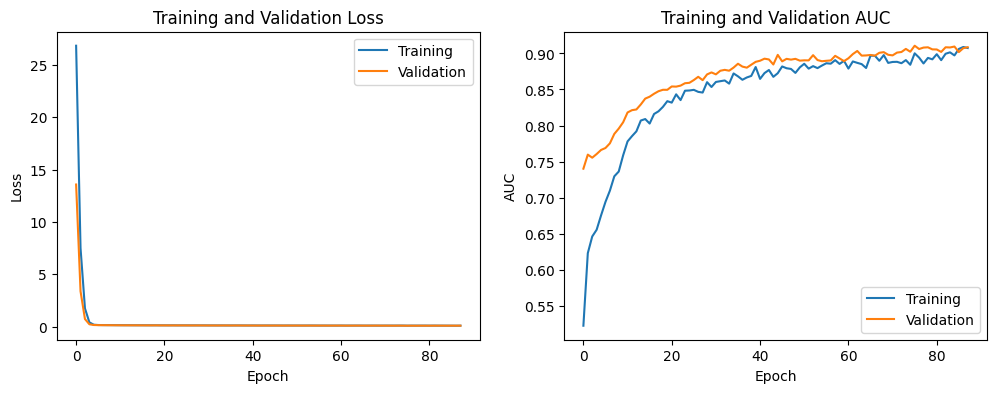

Best Model: Min Training Loss = 0.099, Min Validation Loss = 0.097
Best Model: Max Training AUC = 0.909, Max Validation AUC = 0.911


In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']

# Get number of epochs
epochs = range(len(loss))

# Plot training and validation loss per epoch
axs[0].plot(epochs, loss)
axs[0].plot(epochs, val_loss)
legend_drawn_flag = True
axs[0].legend(["Training", "Validation"], loc=0, frameon=legend_drawn_flag)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Validation Loss')

# Plot training and validation auc per epoch
axs[1].plot(epochs, auc)
axs[1].plot(epochs, val_auc)
axs[1].legend(["Training", "Validation"], loc=0, frameon=legend_drawn_flag)
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('AUC')
axs[1].set_title('Training and Validation AUC')

plt.show()

print('Best Model: Min Training Loss = {:.3f}, Min Validation Loss = {:.3f}'
      .format(min(loss), min(val_loss)))
print('Best Model: Max Training AUC = {:.3f}, Max Validation AUC = {:.3f}'
      .format(max(auc), max(val_auc)))

In [9]:
model.save('model.h5')

In [10]:
y_out, saved_model = run_model(xuser_test, xact_test, 'model.h5')

27/27 [==============================] - 0s 2ms/step


In [11]:
threshold_opt, cr, cm = eval_model(y_test, y_out, saved_model)

Optimum threshold: 0.46
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       567
           1       0.71      0.87      0.78       284

    accuracy                           0.84       851
   macro avg       0.82      0.84      0.82       851
weighted avg       0.85      0.84      0.84       851

[[465 102]
 [ 38 246]]


## Inference Recommendations for New User

In [12]:
new_user = {'user_id': 115,
            'user_name': 'Made Atma',
            'age': 28,
            'gender': 0,
            'email': 'Made@gmail.com',
            'passwords': 'Akumasih-28',
            'latitude': -6.881259902393751,
            'longitude': 107.61176305837027,
            'interest_sports': 1,
            'interest_arts': 0.2,
            'interest_travel': 0.6,
            'interest_edu': 0,
            'travel_dist': ">50 Km"
           }

rank, y_out = user_inference(new_user)
rank

C:\Users\User\AppData\Local\Temp\ipykernel_3400\85732756.py:176: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1_rad = math.radians(lat1)
C:\Users\User\AppData\Local\Temp\ipykernel_3400\85732756.py:177: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lon1_rad = math.radians(lon1)


1/1 [==============================] - 0s 146ms/step


Index([23, 24, 20, 22, 25,  5,  1, 14, 31,  3,  4, 19, 15,  6, 21, 32,  2, 11,
       18, 26,  7,  8, 17, 27, 13, 29, 28,  9, 12, 10, 30, 16],
      dtype='int64')